In [1]:
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
application_train = pd.read_csv("../input/application_train.csv") 
application_test = pd.read_csv("../input/application_test.csv")

In [3]:
df = application_train.append(application_test).reset_index(drop=True)

In [4]:
# clear the memory
del application_train
del application_test
gc.collect()

19

## Processing from EDA
- Flag anomalies
- remove XNA category from CODE_GENDER
- remove float columns that have low variance

In [5]:
df = df[df['CODE_GENDER'] != 'XNA']
df['CODE_GENDER'].value_counts() 

F    235126
M    121125
Name: CODE_GENDER, dtype: int64

In [5]:
df = df[df['CODE_GENDER'] != 'XNA']

# Create an anomalous flag column
df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243
# Replace the anomalous values with nan
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [6]:
df = df.drop(['REGION_POPULATION_RELATIVE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 
              'NONLIVINGAPARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
              'COMMONAREA_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
              'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MODE',
              'BASEMENTAREA_MEDI', 'LANDAREA_MEDI', 'BASEMENTAREA_AVG', 'LIVINGAPARTMENTS_AVG',
              'LIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MODE',
              'YEARS_BUILD_MEDI', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE',
              'AMT_REQ_CREDIT_BUREAU_HOUR', 'APARTMENTS_MODE', 'APARTMENTS_AVG', 'APARTMENTS_MEDI',
              'TOTALAREA_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'FLOORSMIN_MODE',
              'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'AMT_REQ_CREDIT_BUREAU_DAY', 'ELEVATORS_MODE'],
             axis=1)

## Encoding categorical variables

The problem with label encoding is that it gives the categories an arbitrary ordering. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

In [7]:
# label encoding
def label_encoding(data):
    bin_features =[]
    for col in data:
        if data[col].dtype == 'object' and len(list(data[col].unique())) <= 2:
            bin_features.append(col)
    
    for bin_feature in bin_features: #['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    return df
df = label_encoding(df)

In [8]:
# one-hot encoding
df = pd.get_dummies(df)

print('Data Features shape: ', df.shape)

Data Features shape:  (356251, 201)


The label encoding and ont-hot encoding will create uint8 and int64 columns
### Some new features

In [9]:
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# Fitting on main dataset only
Final pre-processing
- Separate train and test
- Missing value imputation

In [10]:
# separate train and test
train_labels = df[df['TARGET'].notnull()].TARGET.values
train_df = df[df['TARGET'].notnull()].drop(['TARGET','SK_ID_CURR'],axis=1)
test_df = df[df['TARGET'].isnull()].drop(['TARGET','SK_ID_CURR'],axis=1)

In [20]:
print('Training data shape: ', train_df.shape)

Training data shape:  (307507, 204)


In [11]:
train = train_df.copy()
test = test_df.copy()

features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(test)

## Random Forest
- hyperparameter tuning
- select best k features
- cross validation score
- make prediction and submit file

In [37]:
# select the best k features
selector = SelectKBest(f_classif, k=100)
train_kbest = selector.fit_transform(train, train_labels)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

print('Cross validation ROC AUC score is: ',
      cross_val_score(random_forest, train_kbest, train_labels, scoring='roc_auc').mean())
print('Cross validation log loss score is: ',
      cross_val_score(random_forest, train_kbest, train_labels, scoring='neg_log_loss').mean())

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


Cross validation ROC AUC score is:  0.7195166662654712


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s


Cross validation log loss score is:  -0.2710269723185152


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


In [12]:
selector = SelectKBest(f_classif, k=100)
train_kbest = selector.fit_transform(train, train_labels)
test[:,selector.get_support()].shape

(48744, 100)

In [48]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train_kbest, train_labels)
predictions = random_forest.predict_proba(test[:,selector.get_support()])[:, 1]

# Submission dataframe
submit = df[df['TARGET'].isnull()][['SK_ID_CURR']] # double bracket is dataframe
submit['TARGET'] = predictions
submit.to_csv('../submission/random_forest.csv', index = False)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


0.697 (with 5 new features) - > 0.705 (remove 41 low variance variables) -> 0.718 (with SelectKBest, 0.719 is the actual score)

In [26]:
df.shape

(356251, 206)

In [28]:
# save df to csv
df_save = df[['TARGET','SK_ID_CURR']].merge(df.drop(['TARGET','SK_ID_CURR'], axis=1).loc[:,selector.get_support()],
                                 left_index=True, right_index=True)


df_save.to_csv('../input/application_df.csv', index = False)

# Fitting on All datasets

In [4]:
install_features = pd.read_csv("../input/install_features.csv") 
previous_features = pd.read_csv("../input/previous_features.csv")
other_features = pd.read_csv("../input/other_features.csv")
df_save = pd.read_csv("../input/application_df.csv")

df_joined = df_save.merge(install_features, how='left', on='SK_ID_CURR')
df_joined = df_joined.merge(previous_features, how='left', on='SK_ID_CURR')
df_joined = df_joined.merge(other_features, how='left', on='SK_ID_CURR')

print('Data Features shape: ', df_joined.shape)

Data Features shape:  (356251, 628)


In [17]:
#del install_features
#del previous_features
#del other_features
#del df_save

gc.collect()

571

In [9]:
# separate train and test
train_labels = df_joined[df_joined['TARGET'].notnull()].TARGET.values
train_df_joined = df_joined[df_joined['TARGET'].notnull()].drop(['TARGET','SK_ID_CURR'],axis=1)
test_df_joined = df_joined[df_joined['TARGET'].isnull()].drop(['TARGET','SK_ID_CURR'],axis=1)

train = train_df_joined.copy()
test = test_df_joined.copy()

features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(test)

In [193]:
m = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

print('Cross validation ROC AUC score is: ',
      cross_val_score(m, train, train_labels, scoring='roc_auc').mean())

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


Cross validation ROC AUC score is:  0.7222389866334544


The score is not a big improvement from the model built on main dataset. Since we have over 600 features, we want to remove those that are not useful next to improve the metric score
# Feature Engineering

### 1. Compare features with random values using feature importance from random forest

In [24]:
train_df = pd.DataFrame(data=train, columns=train_df_joined.columns)
test_df = pd.DataFrame(data=train, columns=train_df_joined.columns)

In [91]:
features_int = train_df_joined.select_dtypes(include=['int64','bool'])

In [123]:
# Add a random column to which features can be compared
train_df['random'] =  np.random.random(size=len(train_df))

train_df['random_int'] = np.random.randint(2,size=len(train_df))

In [190]:
from sklearn.ensemble import ExtraTreesClassifier
m = ExtraTreesClassifier()
m.fit(train_df, train_labels)

In [70]:
df_features = pd.DataFrame(columns = ['variable', 'contribution'])
df_features['contribution'] = pd.Series(m.feature_importances_)
df_features['variable'] = pd.Series(train_df.columns)

In [71]:
df_features[df_features['variable']=='random']

,variable,contribution
626,random,0.005341


In [73]:
df_features[df_features['variable']=='random_int']

,variable,contribution
627,random_int,0.004199


In [77]:
df_features[df_features['contribution']>=0.005341].sort_values(by='contribution',ascending = False)

,variable,contribution
18,EXT_SOURCE_2,0.014499
19,EXT_SOURCE_3,0.010077
17,EXT_SOURCE_1,0.006399
8,DAYS_BIRTH,0.006159
98,ANNUITY_INCOME_PERC,0.006025
10,DAYS_ID_PUBLISH,0.005791
102,INSTAL_DPD_MEAN,0.005692
11,DAYS_LAST_PHONE_CHANGE,0.005456
12,DAYS_REGISTRATION,0.005454
136,PREV_CNT_PAYMENT_MEAN,0.005395


In [148]:
df_features[(df_features['contribution']<0.005341) & (df_features['contribution']>0.004199)].shape

(61, 2)

In [195]:
# fit random forest with top 12 important features
imp_features = df_features[df_features['contribution']>=0.005341].variable.values

m = RandomForestClassifier(n_estimators = 15, random_state = 50, verbose = 1, n_jobs = -1)

print('Cross validation ROC AUC score is: ',
      cross_val_score(m, train_df[imp_features], train_labels, scoring='roc_auc').mean())

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished


Cross validation ROC AUC score is:  0.6726498937537772


0.67 (12 variables)

### 2. Estimate permutation importance for 73 features

In [208]:
def oob_classifier_roc_auc(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = roc_auc_score(y, predicted_classes)
    return oob_score

def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [209]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.metrics import roc_auc_score, log_loss
imp_features = df_features[df_features['contribution']>=0.004199].variable.values #004199

In [212]:
rf = RandomForestClassifier(n_jobs = -1)
rf.fit(train_df[imp_features], train_labels) # rf must be pre-trained
imp = permutation_importances(rf, train_df[imp_features], train_labels,
                              oob_classifier_roc_auc)

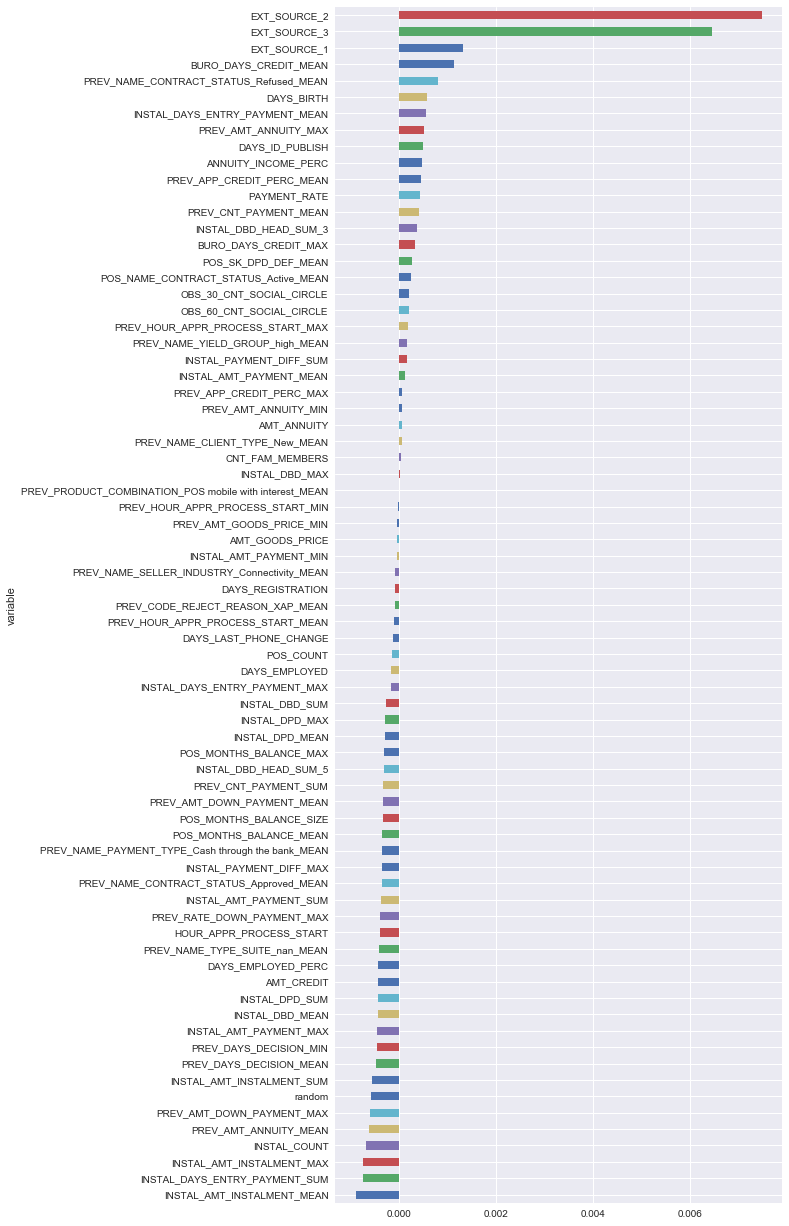

In [213]:
importance_df = pd.DataFrame({'variable':imp_features, 'importance':imp}).sort_values(by='importance',ascending = True)
p = importance_df.plot(x = 'variable', y = 'importance', kind='barh',figsize = (8,22), legend=False)
plt.show()

In [217]:
l2 = importance_df[importance_df['importance']>0].variable.values

In [228]:
l2

array(['INSTAL_DBD_MAX', 'CNT_FAM_MEMBERS',
       'PREV_NAME_CLIENT_TYPE_New_MEAN', 'AMT_ANNUITY',
       'PREV_AMT_ANNUITY_MIN', 'PREV_APP_CREDIT_PERC_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_PAYMENT_DIFF_SUM',
       'PREV_NAME_YIELD_GROUP_high_MEAN',
       'PREV_HOUR_APPR_PROCESS_START_MAX', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
       'POS_SK_DPD_DEF_MEAN', 'BURO_DAYS_CREDIT_MAX',
       'INSTAL_DBD_HEAD_SUM_3', 'PREV_CNT_PAYMENT_MEAN', 'PAYMENT_RATE',
       'PREV_APP_CREDIT_PERC_MEAN', 'ANNUITY_INCOME_PERC',
       'DAYS_ID_PUBLISH', 'PREV_AMT_ANNUITY_MAX',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_BIRTH',
       'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_DAYS_CREDIT_MEAN',
       'EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2'], dtype=object)

In [227]:
# fit random forest on 33 important features
m = RandomForestClassifier(n_estimators = 15, random_state = 50, verbose = 1, n_jobs = -1)

print('Cross validation ROC AUC score is: ',
      cross_val_score(m, train_df[l2], train_labels, scoring='roc_auc').mean())

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished


Cross validation ROC AUC score is:  0.6739589642238442


### Tune hyperparameters of rf model and make prediction for test data

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [25, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,9]
}

rf = RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc')
CV_rfc.fit(train_df[l2], train_labels)

In [233]:
CV_rfc.best_params_

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 25}

In [ ]:
predictions = random_forest.predict_proba(test[l2])[:, 1]

# Submission dataframe
submit = df_joined[df_joined['TARGET'].isnull()][['SK_ID_CURR']] # double bracket is dataframe
submit['TARGET'] = predictions
submit.to_csv('../submission/rf_33features.csv', index = False)